# Importamos bibliotecas necesarias

In [1]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Para importar Notebooks propias

##### Desde Jupyter no se importar archivos python planos, sino notebooks que tienen una codificación mas complicada. Para poder importar una notebook correctamente hay que agregar los siguientes métodos (tomado de https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html)

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [4]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

# Importamos biblioteca propia

In [7]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import Desafio_2_aux

importing Jupyter notebook from Desafio_2_aux.ipynb


# Leer el data set desde el archivo csv

In [8]:
pathArchivoDataSet = 'properatti_2.csv'
df = pd.read_csv(pathArchivoDataSet)

In [9]:
df.head(5)

,property_type,place_name,state_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
0,PH,mataderos,Capital Federal,62000.0,40.000000,15.0,1127.272727,2.0,-34.666326,-58.519094,0,0,0,0,0
1,apartment,la plata,Bs.As. G.B.A. Zona Sur,150000.0,69.891566,0.0,2146.181693,3.0,-34.924277,-57.965973,0,1,1,0,0
2,apartment,mataderos,Capital Federal,72000.0,55.000000,0.0,1309.090909,2.0,-34.666326,-58.519094,0,0,0,0,0
3,PH,liniers,Capital Federal,95000.0,92.565511,0.0,1026.300175,3.0,-34.643508,-58.516984,0,0,0,0,0
4,apartment,centro,Buenos Aires Costa Atlántica,64000.0,35.000000,0.0,1828.571429,4.0,-38.000247,-57.547260,0,0,0,0,0


# Definimos el subset de datos del cual generaremos el modelo

### Nos quedamos con el subset de datos relacionados a Capital Federal

In [10]:

filtroParaElSubsetDeDatos = ['La Rioja', 'Salta', 'Jujuy', 'Misiones', 'Entre Ríos', 'Corrientes', 'Tucumán', 'Formosa',\
                             'Chaco', 'Catamarca']

In [11]:
df_subset = Desafio_2_aux.getSubDataFrameByStateName(df, filtroParaElSubsetDeDatos)

Sub data frame Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2082 entries, 5 to 109220
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              2082 non-null   object 
 1   place_name                 2082 non-null   object 
 2   price                      2082 non-null   float64
 3   surface_covered_in_m2      2082 non-null   float64
 4   surface_not_covered_in_m2  2082 non-null   float64
 5   price_usd_per_m2           2082 non-null   float64
 6   rooms                      2082 non-null   float64
 7   lat_mediaPorZona           2082 non-null   float64
 8   lon_mediaPorZona           2082 non-null   float64
 9   pileta                     2082 non-null   int64  
 10  cochera                    2082 non-null   int64  
 11  balcon                     2082 non-null   int64  
 12  terraza                    2082 non-null   int64  
 13  parrilla               

# Analizamos outliers y los sacamos del data frame

### Vemos la distribucion de los datos en gráficos para tratar de identificar los outliers que tenemos

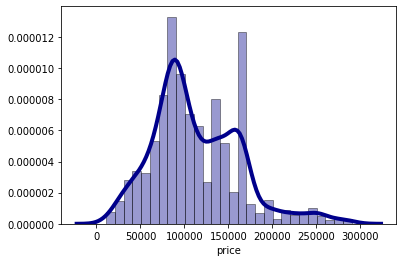

In [12]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price')


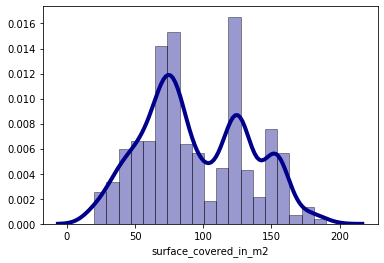

In [13]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_covered_in_m2')

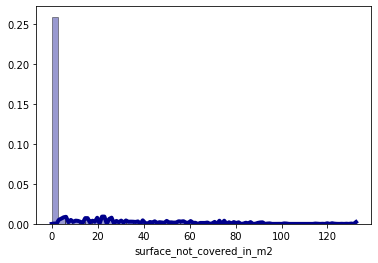

In [14]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'surface_not_covered_in_m2')

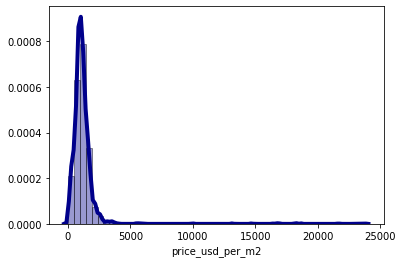

In [15]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'price_usd_per_m2')

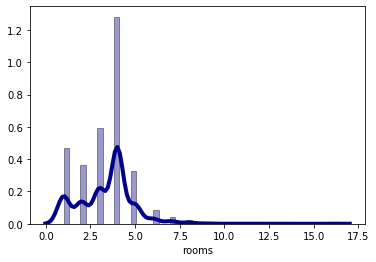

In [16]:
Desafio_2_aux.drawUniqueDensityPlot(df_subset, 'rooms')

### Removemos los outliers

In [17]:
df_subset.describe()

,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,parrilla
count,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000
mean,113212.155537,94.626858,8.498922,1200.297125,3.408742,-29.478714,-60.805998,0.098943,0.298751,0.109030,0.085495,0.085495
std,49757.341869,38.670571,19.983916,1317.838117,1.543407,3.600178,3.743223,0.298658,0.457820,0.311751,0.279684,0.279684
min,10857.142857,20.000000,0.000000,5.608367,1.000000,-38.416097,-65.972548,0.000000,0.000000,0.000000,0.000000,0.000000
25%,79644.987500,67.000000,0.000000,785.171436,2.000000,-33.009015,-65.212692,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100879.310185,85.000000,0.000000,1065.038281,4.000000,-27.417425,-58.666472,0.000000,0.000000,0.000000,0.000000,0.000000
75%,145000.000000,126.235356,0.000000,1386.104056,4.000000,-26.823398,-58.168589,0.000000,1.000000,0.000000,0.000000,0.000000
max,290000.000000,190.000000,132.428571,23750.000000,16.000000,-23.137164,-54.580379,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
#removemos datos por outliers de precio por m2
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'price_usd_per_m2', 500, 3000)

In [19]:
#removemos outliers por rooms
df_subset = Desafio_2_aux.removeRowsWithOutliersFromDataFrame(df_subset, 'rooms', 1, 8)

In [20]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_type              1819 non-null   object 
 1   place_name                 1819 non-null   object 
 2   price                      1819 non-null   float64
 3   surface_covered_in_m2      1819 non-null   float64
 4   surface_not_covered_in_m2  1819 non-null   float64
 5   price_usd_per_m2           1819 non-null   float64
 6   rooms                      1819 non-null   float64
 7   lat_mediaPorZona           1819 non-null   float64
 8   lon_mediaPorZona           1819 non-null   float64
 9   pileta                     1819 non-null   int64  
 10  cochera                    1819 non-null   int64  
 11  balcon                     1819 non-null   int64  
 12  terraza                    1819 non-null   int64  
 13  parrilla                   1819 non-null   int64

# Analizamos las variables categóricas

ituzaingó                     471
posadas                       271
san miguel de tucumán         248
salta                         210
yerba buena                   132
paraná                        113
colón                          97
tucumán                        43
resistencia                    32
concordia                      24
tafí del valle                 17
tafí viejo                     16
gualeguaychú                   14
victoria                       12
san salvador de jujuy          10
cerrillos                       9
cafayate                        9
garupá                          8
nogoyá                          7
paso de la patria               7
rosario de lerma                6
concepción del uruguay          6
corrientes                      5
federación                      5
oro verde                       4
oberá                           4
san josé                        4
villa urquiza                   3
candelaria                      3
misiones      

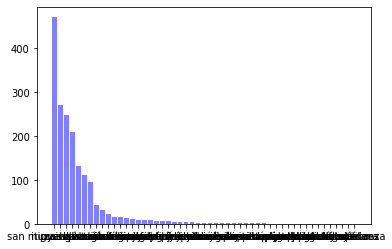

house        936
apartment    764
PH            68
store         51
Name: property_type, dtype: int64


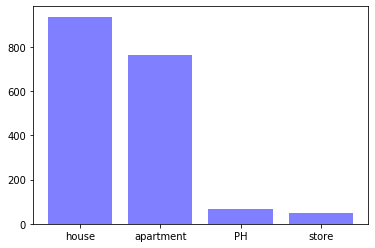

In [21]:
Desafio_2_aux.analyzeCategoricalData(df_subset, ['place_name', 'property_type'])

### Creamos variables dummies a partir de la variable categorica

In [22]:
df_subset = Desafio_2_aux.createDummiesForVariables(df_subset, ['place_name', 'property_type'])

In [23]:
df_subset.head()

,property_type,place_name,price,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,...,place_name_tafí del valle,place_name_tafí viejo,place_name_tucumán,place_name_victoria,place_name_villa elisa,place_name_villa urquiza,place_name_yerba buena,property_type_apartment,property_type_house,property_type_store
0,house,gualeguaychú,98333.333333,53.000000,0.0,1855.345912,4.0,-33.009015,-58.521993,0,...,0,0,0,0,0,0,0,0,1,0
1,house,posadas,200000.000000,80.033412,0.0,888.888889,5.0,-27.417425,-55.937294,0,...,0,0,0,0,0,0,0,0,1,0
2,house,posadas,110934.636901,80.033412,0.0,1181.839923,5.0,-27.417425,-55.937294,0,...,0,0,0,0,0,0,0,0,1,0
3,apartment,salta,75991.920625,71.351351,0.0,1065.038281,4.0,-24.793481,-65.424285,0,...,0,0,0,0,0,0,0,1,0,0
4,apartment,salta,75991.920625,71.351351,0.0,1065.038281,3.0,-24.793481,-65.424285,0,...,0,0,0,0,0,0,0,1,0,0


# Guardamos un data frame auxiliar con la relacion entre los dummies y el dato place_name

### Data frame auxiliar para place name

In [24]:
place_name_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'place_name')
place_name_dummies

,place_name,place_name_apóstoles,place_name_banda del río salí,place_name_barranqueras,place_name_bella vista,place_name_cafayate,place_name_campo grande,place_name_campo quijano,place_name_candelaria,place_name_caseros,...,place_name_san ramón de la nueva orán,place_name_san salvador de jujuy,place_name_santa ana,place_name_tafí del valle,place_name_tafí viejo,place_name_tucumán,place_name_victoria,place_name_villa elisa,place_name_villa urquiza,place_name_yerba buena
0,gualeguaychú,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,posadas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,salta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,paraná,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,apóstoles,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,tucumán,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14,yerba buena,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18,resistencia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,victoria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
20,colón,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data frame auxiliar para property_type

In [25]:
proeprty_type_dummies = Desafio_2_aux.generateAuxiliarDataFrameForDummies(df_subset, 'property_type')
proeprty_type_dummies

,property_type,property_type_apartment,property_type_house,property_type_store
0,house,0,1,0
3,apartment,1,0,0
7,PH,0,0,0
26,store,0,0,1


# Generamos el objeto para el K Fold

In [26]:
#generamos un K Fold de 5 pasos para el entrenamiento de los modelos
cv = KFold(5, shuffle=True, random_state=10)

# Quitamos las columnas que no van a estar en el modelo

In [27]:
#quitamos las columnas que no van a participar en el modelo
df_model_columns = df_subset.drop(labels= ["price", "property_type", "place_name"], axis=1)
df_model_columns

,surface_covered_in_m2,surface_not_covered_in_m2,price_usd_per_m2,rooms,lat_mediaPorZona,lon_mediaPorZona,pileta,cochera,balcon,terraza,...,place_name_tafí del valle,place_name_tafí viejo,place_name_tucumán,place_name_victoria,place_name_villa elisa,place_name_villa urquiza,place_name_yerba buena,property_type_apartment,property_type_house,property_type_store
0,53.000000,0.0,1855.345912,4.0,-33.009015,-58.521993,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,80.033412,0.0,888.888889,5.0,-27.417425,-55.937294,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,80.033412,0.0,1181.839923,5.0,-27.417425,-55.937294,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,71.351351,0.0,1065.038281,4.0,-24.793481,-65.424285,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,71.351351,0.0,1065.038281,3.0,-24.793481,-65.424285,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,73.538462,0.0,810.265028,4.0,-28.088718,-65.021715,0,1,1,1,...,0,0,1,0,0,0,0,1,0,0
1815,115.220382,0.0,1093.631650,4.0,-26.823398,-65.212692,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1816,115.220382,0.0,757.985894,4.0,-26.823398,-65.212692,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1817,155.538462,0.0,1076.895880,4.0,-26.813276,-65.295010,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


# Generamos un modelo con Regresion Lineal

In [28]:
#definimos como variables para entrenamiento todas las del data frame excepto el precio por m2
#el valor precio por m2 será lo que el modelo intente calcular
X = df_model_columns.drop('price_usd_per_m2', axis=1)
y = df_model_columns['price_usd_per_m2']

In [29]:
#seleccionamos un tamaño para el set de test del 1% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=10)

### Realizamos un entrenamiento con el k fold con k = 5

In [30]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
regresionLineal_model, regresionLineal_predicciones, df_regresion_lineal_prediccion_vs_real, scores_lineal = \
                Desafio_2_aux.generateSimpleLinearRegression(X_train, X_test, y_train, y_test, cv)

Score regresión lineal con 5-fold: [-7.28401060e+26 -1.89589863e+27 -8.04696921e+26 -1.01771424e+25
 -4.68880779e+24]



Intercept: 
1186.748996368386



Coeficientes: 
[-2.18701463e+02 -1.31270944e+02 -2.05639822e+00 -4.17418582e+15
 -5.99524123e+15  3.02619904e+01 -8.41429079e+00  7.27551703e+00
  9.05558312e+00  3.22058635e-01  2.92297970e+14 -2.87468971e+14
  2.58112471e+14  4.29032271e+12 -1.44507890e+14  3.46267372e+14
  3.31711808e+11  5.25819169e+14  9.95380526e+12  4.87810933e+12
  8.05334580e+14  1.84329026e+14  5.50828948e+14  1.01903520e+14
  4.16602000e+14 -2.87468971e+14  3.75469933e+14  2.84713355e+14
  8.47845183e+14  1.89718391e+14  4.22912652e+13 -1.95539570e+14
  4.43081457e+14  4.99628165e+13  3.47605001e+14  1.25209922e+13
  8.88402788e+13  5.29740687e+14  1.93489855e+14  4.52245725e+15
  8.62136846e+13  3.86003705e+14  3.98433675e+14  3.90052657e+14
  1.01663749e+15 -5.39348314e+12  8.93205701e+13  1.46764606e+14
  8.63740508e+13 -5.74057640e+14  9.30722782e+13  8

In [31]:
df_regresion_lineal_prediccion_vs_real

,Real,Predichos,Diferencia
1375,868.080210,1049.566599,-181.486389
435,1101.418912,1263.566599,-162.147687
1197,1940.819175,1305.316599,635.502576
1479,1522.222222,1438.561423,83.660799
1014,1996.891632,1366.061423,630.830208
1787,742.773434,1105.592673,-362.819239
693,1101.418912,1106.066599,-4.647687
1734,1546.529714,1537.467673,9.062041
1079,1270.694537,1362.816599,-92.122062
1391,1510.097865,1451.066599,59.031266


# Redefinimos los data frames para modelar, ya que ahora necesitamos un subconjunto de prueba sobre el data frame total

In [32]:
#seleccionamos un tamaño para el set de test del 25% del data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Generamos el modelo para Ridge Cross Validation

In [33]:
#el metodo devuelve el modelo, las predicciones y un data frame para comparar valores reales vs obtenidos
model_ridge, RidgeCV_predicciones, df_ridge_prediccion_vs_real, model_ridge_score = \
                Desafio_2_aux.generateRidgeCV(X_train, X_test, y_train, y_test, np.linspace(4,10,500), cv)

Score Ridge CV: [0.32880997 0.33555842 0.36108537 0.32818327 0.38653483]
Alpha Ridge CV: 4.0
Coeficientes:  [-236.90318574 -130.82535672    3.94093848  -41.64845342   22.64801705
   31.75811806   -7.52460646   14.77679499   11.97373014   -1.9027529
  -20.00891062   -5.8101814     1.97601147   13.0995644   -13.26104205
   24.62674387    7.77397545    6.07875253   -4.03025905   24.64186026
   45.77700828   -1.67374302    4.08730498    1.17542784   21.50751382
    0.            0.           28.1642044   -36.70940155   11.99764802
   74.7256668    34.3120886    -2.71456117    9.27573661  -20.94521948
  -23.69558263  -32.34007868  -19.45582395   -5.42401839  -14.59029846
    0.          -14.20102868   16.30459576    0.            6.92653904
    5.21374547  -10.52155238    0.           -8.9071257   -13.47074799
  -15.05528947   -3.30981321    0.          -35.50247279   -7.75530002
  -35.86257539   11.94447096   -4.5395834    23.60410338   45.13474324
  100.77704343  125.99931387   30.6996082

In [34]:
df_ridge_prediccion_vs_real

,Real,Predichos,Diferencia
1375,868.080210,1034.777122,-166.696913
435,1101.418912,1269.384825,-167.965913
1197,1940.819175,1309.448174,631.371000
1479,1522.222222,1472.115675,50.106547
1014,1996.891632,1381.165099,615.726533
...,...,...,...
1055,911.359625,1199.549068,-288.189443
1480,1464.387196,1364.074805,100.312391
976,844.838767,975.203899,-130.365132
608,1316.126681,1286.877305,29.249376


# Generamos el modelo para Lasso Cross Validation

In [35]:
model_lasso, LassoCV_predicciones, df_lasso_prediccion_vs_real, scores_lasso = \
        Desafio_2_aux.generateLassoCV(X_train, X_test, y_train, y_test, np.linspace(0.001,1,300), cv)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureW




Intercept: 



1184.355822307464



Coeficientes: 



[-2.31315981e+02 -1.29443735e+02  2.29509434e-01 -1.00211692e+02
  3.10191240e+00  3.13902912e+01 -4.73340038e+00  1.33922410e+01
  9.45960899e+00 -0.00000000e+00 -1.69194568e+01 -8.94258829e+00
  6.99484012e-01  7.60262361e+00 -1.03255659e+01  2.43714236e+01
  6.83472628e+00  5.99659772e+00 -5.58195236e+00  2.50514272e+01
  3.31167565e+01 -2.44980940e+00 -0.00000000e+00  0.00000000e+00
  2.04733875e+01  0.00000000e+00  0.00000000e+00  2.54293594e+01
 -3.21462549e+01  5.25804934e+00  3.14274175e+01  2.95528571e+01
 -0.00000000e+00  3.88769522e+00 -1.94468727e+01 -2.39617263e+01
 -4.33556549e+01 -1.61521860e+01 -3.73146783e+00 -0.00000000e+00
  0.00000000e+00 -1.05597562e+01  1.67473352e+01  0.00000000e+00
  8.25261811e+00  4.95829842e+00 -0.00000000e+00  0.00000000e+00
 -1.10296464e+01 -1.14993311e+01 -1.14593469e+01  0.00000000e+00
  0.00000000e+00 -3.42760613e+01 -6.13139430e+00 -3.71696022e+01
  2.92676386e+00 -5.26596624e+00 

In [36]:
df_lasso_prediccion_vs_real

,Real,Predichos,Diferencia
1375,868.080210,1031.413276,-163.333066
435,1101.418912,1265.085131,-163.666219
1197,1940.819175,1302.672443,638.146731
1479,1522.222222,1469.124023,53.098199
1014,1996.891632,1385.325319,611.566312
...,...,...,...
1055,911.359625,1195.230333,-283.870708
1480,1464.387196,1348.976522,115.410674
976,844.838767,984.933988,-140.095221
608,1316.126681,1287.232523,28.894158


# Verificamos los resultados

### Visualizamos los scores de los modelos

In [37]:
print("Score Train Lineal: " ,scores_lineal)
print("Score Train Ridge: " , model_ridge_score)
print("Score Train Lasso: " ,  scores_lasso)

Score Train Lineal:  [-7.28401060e+26 -1.89589863e+27 -8.04696921e+26 -1.01771424e+25
 -4.68880779e+24]
Score Train Ridge:  [0.32880997 0.33555842 0.36108537 0.32818327 0.38653483]
Score Train Lasso:  [0.32865609 0.34704145 0.36387913 0.31615131 0.38664996]


### Visualizamos los errores cuadraticos medios

In [38]:
print("Train RMSE Lineal: " + str(np.sqrt(metrics.mean_squared_error(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))))
print("Train RMSE RidgeCV: " + str(np.sqrt(metrics.mean_squared_error(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))))
print("Train RMSE Lasso: " + str(np.sqrt(metrics.mean_squared_error(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))))

Train RMSE Lineal: 287.32321786091717
Train RMSE RidgeCV: 359.71216410311956
Train RMSE Lasso: 360.1586665030877


In [39]:
print ('Train R2 Lineal:', metrics.r2_score(df_regresion_lineal_prediccion_vs_real.Real, df_regresion_lineal_prediccion_vs_real.Predichos))
print ('Train R2 RidgeCV:', metrics.r2_score(df_ridge_prediccion_vs_real.Real, df_ridge_prediccion_vs_real.Predichos))
print ('Train R2 Lasso:', metrics.r2_score(df_lasso_prediccion_vs_real.Real, df_lasso_prediccion_vs_real.Predichos))

Train R2 Lineal: 0.6203215696567788
Train R2 RidgeCV: 0.2911652601519992
Train R2 Lasso: 0.28940444762481954


### Visualizamos en histogramas como aportan los coeficientes en cada modelo

### Coeficientes de la Regresion Lineal

In [40]:
df_coeficientes_lineal = Desafio_2_aux.generateDataFrameFromModelCoeficients(regresionLineal_model.coef_, X.columns)

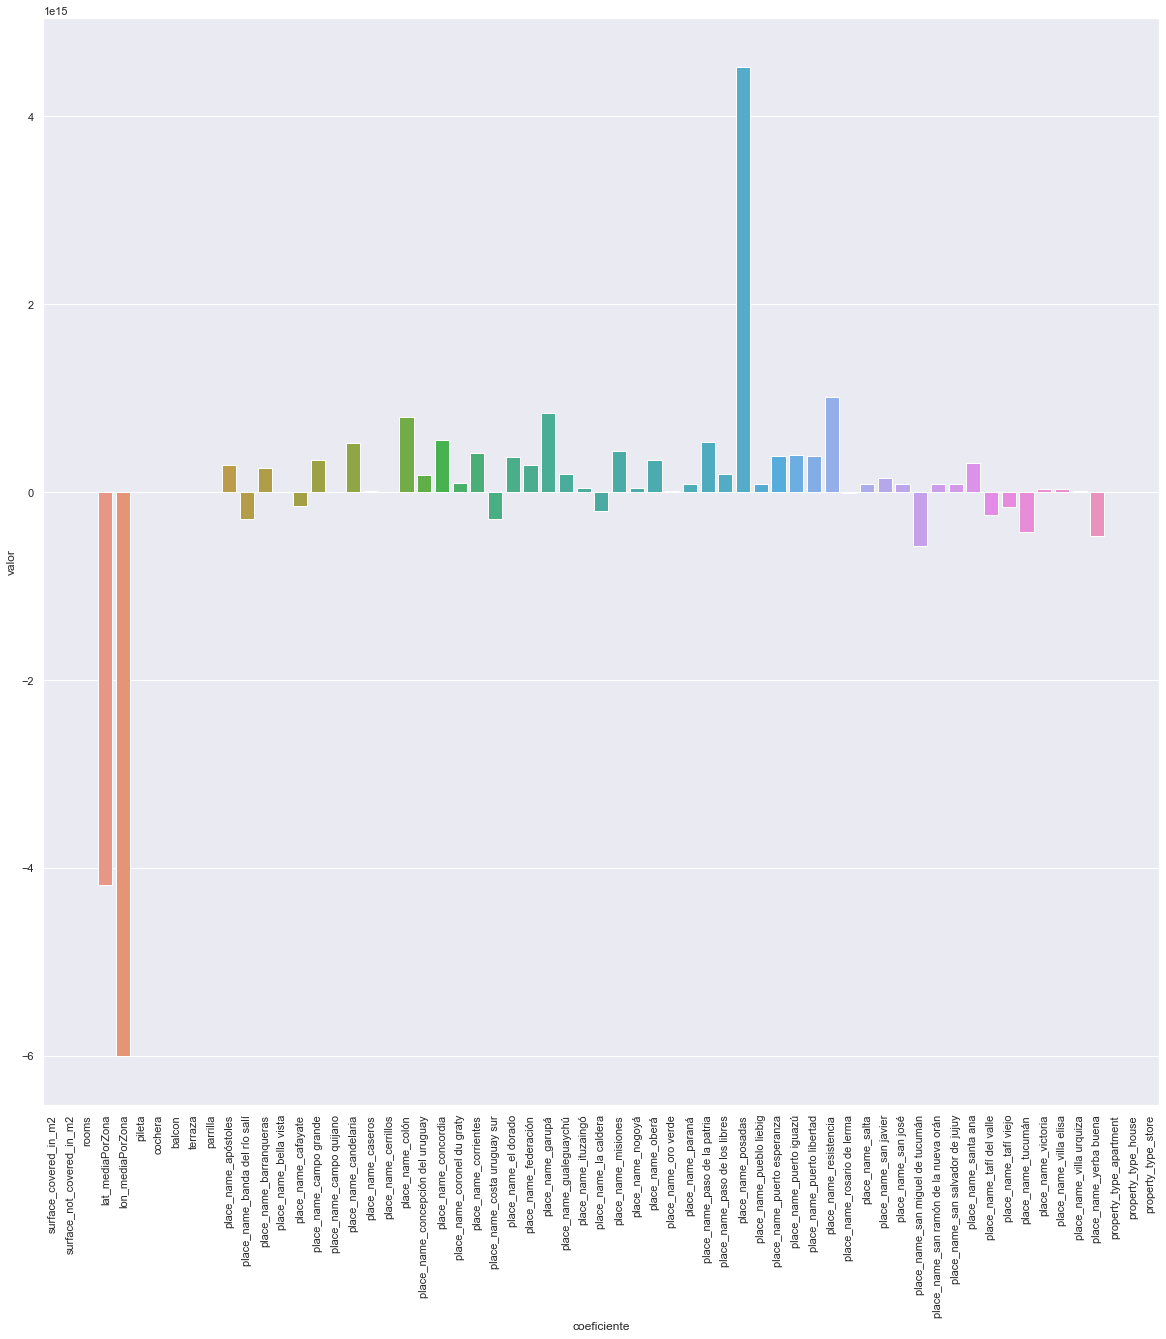

In [41]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lineal);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes RidgeCV

In [42]:
df_coeficientes_ridge = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_ridge.coef_, X.columns)

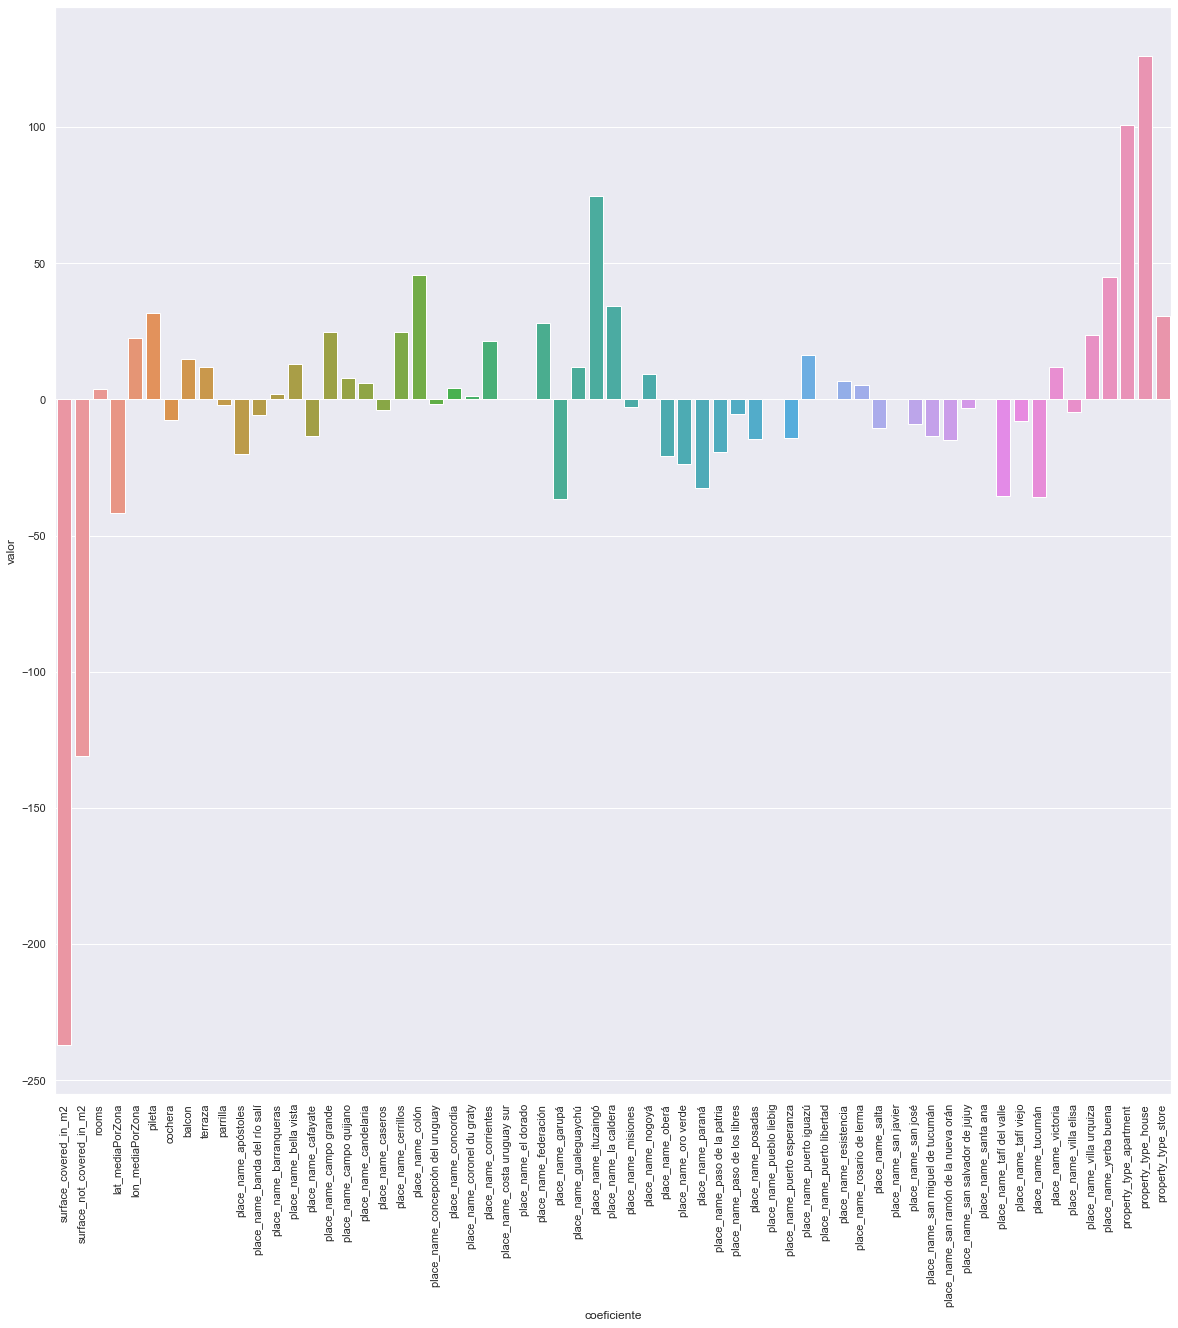

In [43]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_ridge);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Coeficientes para el modelo Lasso

In [44]:
df_coeficientes_lasso = Desafio_2_aux.generateDataFrameFromModelCoeficients(model_lasso.coef_, X.columns)

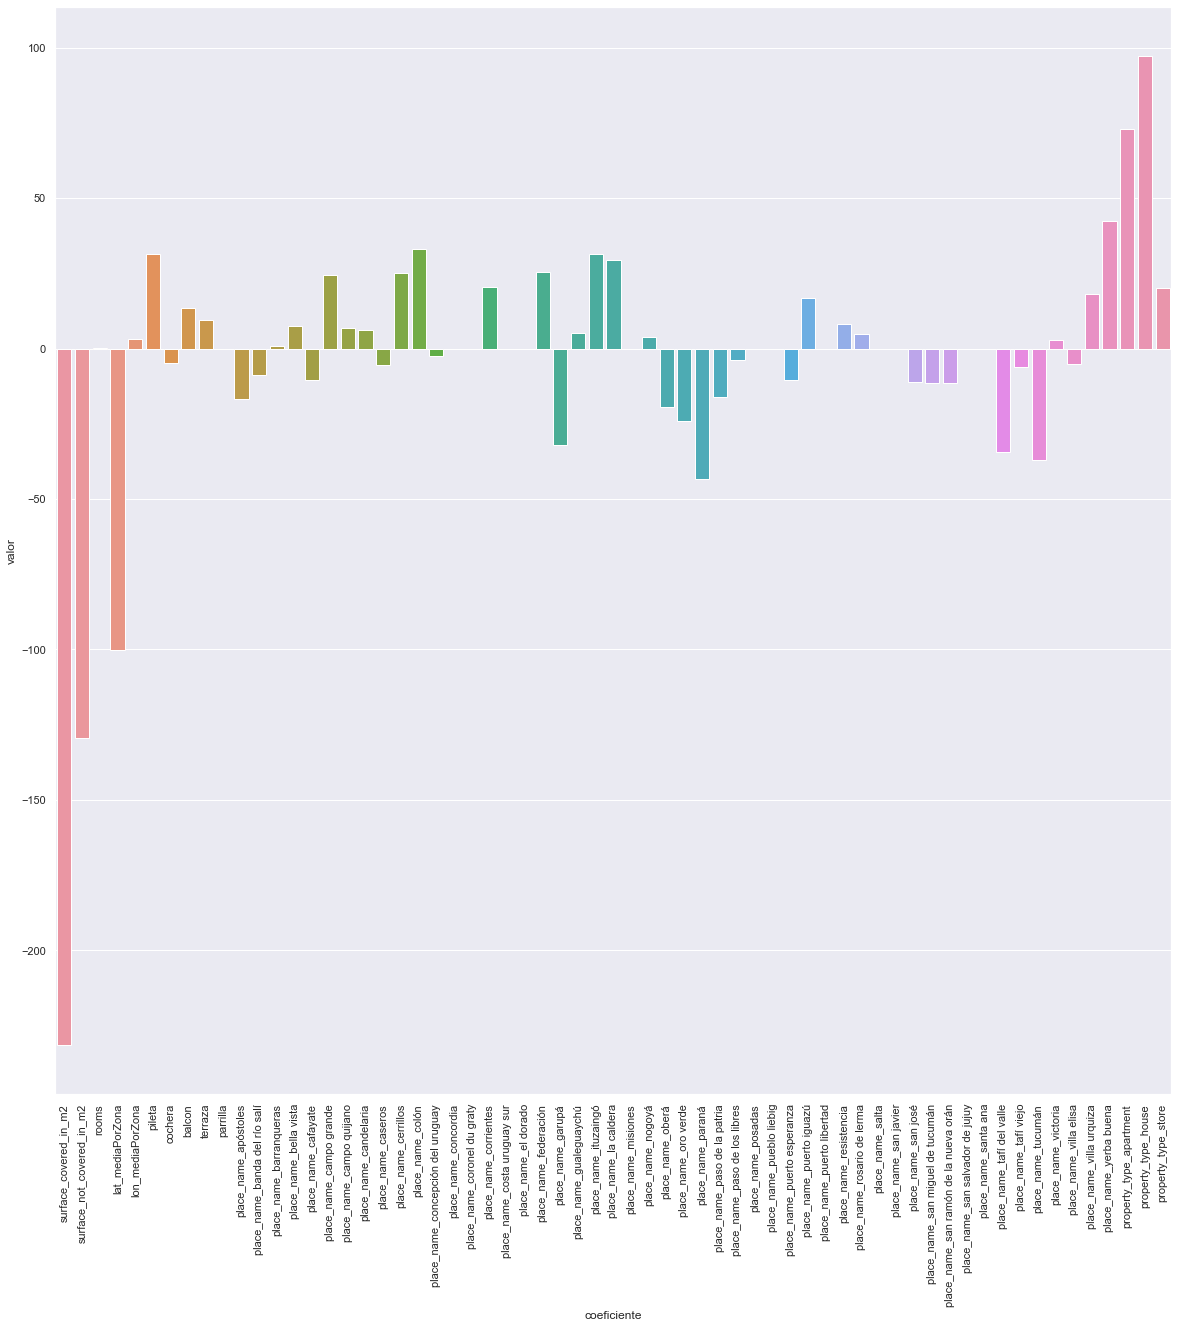

In [45]:
sns.set(rc={'figure.figsize':(20,20)});
ax = sns.barplot(x="coeficiente", y="valor", data=df_coeficientes_lasso);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Una posible mejora que se puede agregar al análisis es ver la diferencia entre los valores predichos vs los valores reales por barrio. Para eso es necesario, cuando se hace el split para el entrenamiento y el testeo, que seleccione subconjuntos de acuerdo a las cantidades de filas para cada barrio. Porque por ejemplo el barrio de Palermo tiene mas de 2000 registros en el dataset, mientras que hay otros barrios, como Parque Chas, que no superan los 20